# notebook minist and different optimizers

the basis is kaiminig optimization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.modelmanager import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from lib.callbacks import *
from pathlib import Path

## mnist data

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [5]:
nh,bs              = 50,512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )
print(len(train_dl)), print(len(valid_dl))

98
10


(None, None)

In [6]:
mnist_view   = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func    = F.cross_entropy
sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = mnist_view), 
#                partial(MixUp,α=0.2),
#                LR_Finder,
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback
               ]



## resnets + steppers=[sgd_step]

In [9]:
opt = SGD(sched,max_lr=0.5)#0.5)
#loss_func=LabelSmoothingCrossEntropy()
loss_func=F.cross_entropy

layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=GeneralRelu )
from torch import *
layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

#model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out)()

xb,_ = mm.getFirstbatch( data, normalization = mnist_view)
print(f"xb.shape:{xb.shape}")
mm.summary(xb, print_mod=False)
learn = Learner( mm.model, data, loss_func=loss_func)

%time learn.fit(3, opt=opt, cb_funcs=cbfs)

xb.shape:torch.Size([512, 1, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([512, 8, 14, 14])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([512, 8, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([512, 16, 7, 7])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([512, 16, 7, 7])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([512, 32, 4, 4])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([512, 32, 4, 4])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([512, 32, 2, 2])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([512, 32, 2, 2])
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'> torch.Size([512, 32, 1, 1])
<class 'lib.model.Lambda'> torch.Size([512, 32])
<class 'torch.nn.modules.linear.Linear'> torch.Size([512, 10])


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.979294,0.696560,0.269771,0.920700,00:08
1,0.230677,0.929680,0.149479,0.956100,00:07
2,0.145594,0.955760,0.125282,0.964300,00:06


CPU times: user 28.4 s, sys: 6.07 s, total: 34.5 s
Wall time: 23.2 s


In [ ]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## steppers=[sgd_step]

In [10]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)
opt = SGD(sched,max_lr=0.8)#0.5)

#loss_func=LabelSmoothingCrossEntropy()
loss_func=F.cross_entropy
learn = Learner( mm.model, data, loss_func=loss_func)

%time learn.fit(3, opt=opt,cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.049124,0.666400,0.266345,0.919200,00:07
1,0.198437,0.938340,0.122837,0.964000,00:07
2,0.111856,0.965280,0.104501,0.968700,00:07


CPU times: user 27.5 s, sys: 5.9 s, total: 33.4 s
Wall time: 22.6 s


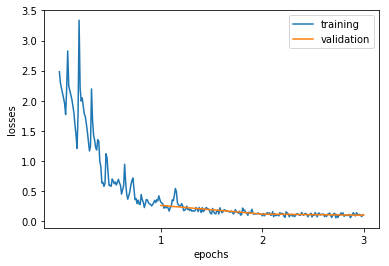

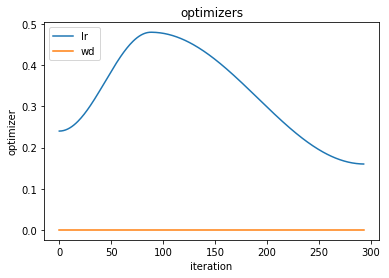

(None, None)

In [11]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## steppers=[weight_decay, sgd_step]

In [12]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt = SGD(sched,max_lr=0.5, max_wd=0.01)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt,cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.024916,0.690640,0.277614,0.919500,00:07


CPU times: user 9.51 s, sys: 2.02 s, total: 11.5 s
Wall time: 7.76 s


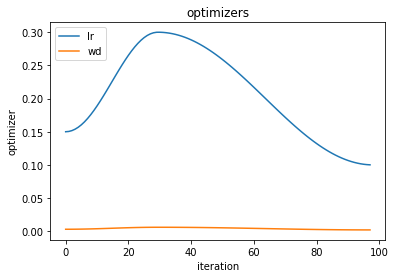

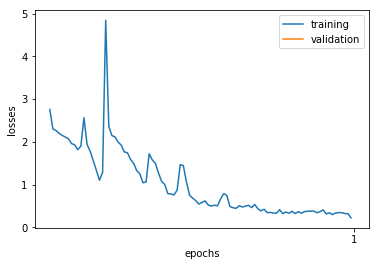

(None, None)

In [13]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [14]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = SGD_Momentum(sched,max_lr=1.0, moms=(0.85,0.95), max_wd=1e-3 )
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.548113,0.468240,0.403727,0.885500,00:07


CPU times: user 9.08 s, sys: 2.13 s, total: 11.2 s
Wall time: 7.42 s


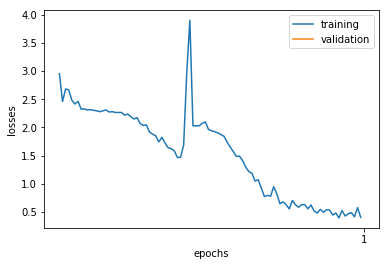

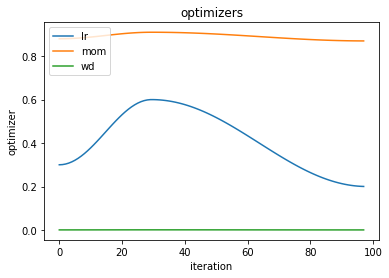

(None, None)

In [15]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=0),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## Adam: steppers=[adam_step]

In [16]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = Adam(sched,max_lr=0.05, moms=(0.85,0.95), max_wd = 1e-3)
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.611748,0.796460,0.164863,0.951600,00:07


CPU times: user 9.2 s, sys: 1.99 s, total: 11.2 s
Wall time: 7.84 s


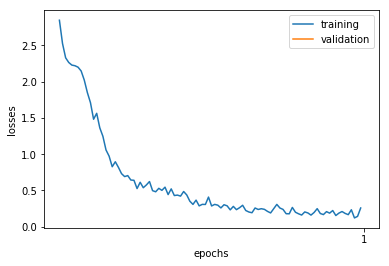

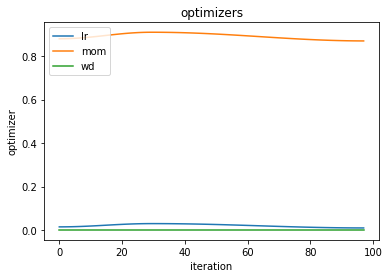

(None, None)

In [18]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=10),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## LAMB: steppers=[lamb_step]

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [19]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = LAMB(sched,max_lr=0.02, moms=(0.85,0.95), max_wd = 1e-4)     
#opt   = LAMB(sched,max_lr=0.005, moms=(0.85,0.95), max_wd = 1e-4)     #with mixup
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.570077,0.817920,0.143179,0.956100,00:07


CPU times: user 8.97 s, sys: 2 s, total: 11 s
Wall time: 7.01 s


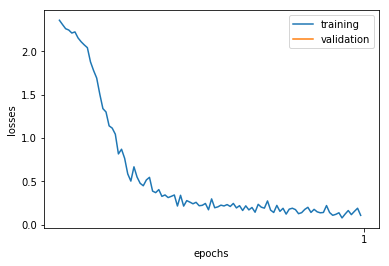

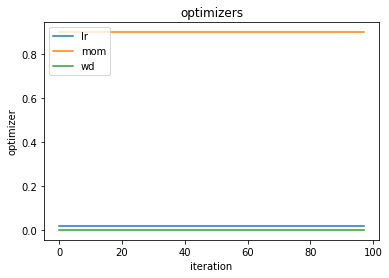

(None, None)

In [20]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## mnist with adam and hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.775794,0.746940,0.181642,0.945900,00:08
1,0.149127,0.955560,0.116724,0.965300,00:08
2,0.099225,0.970820,0.091174,0.974000,00:08


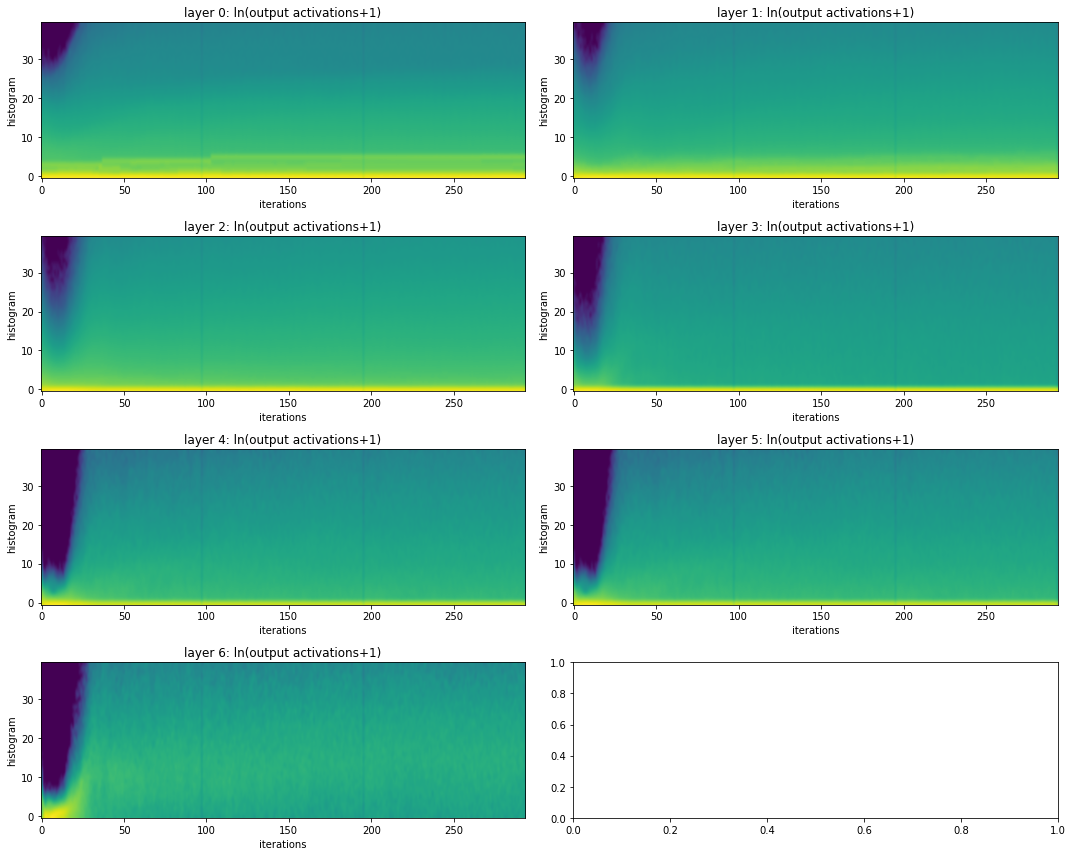

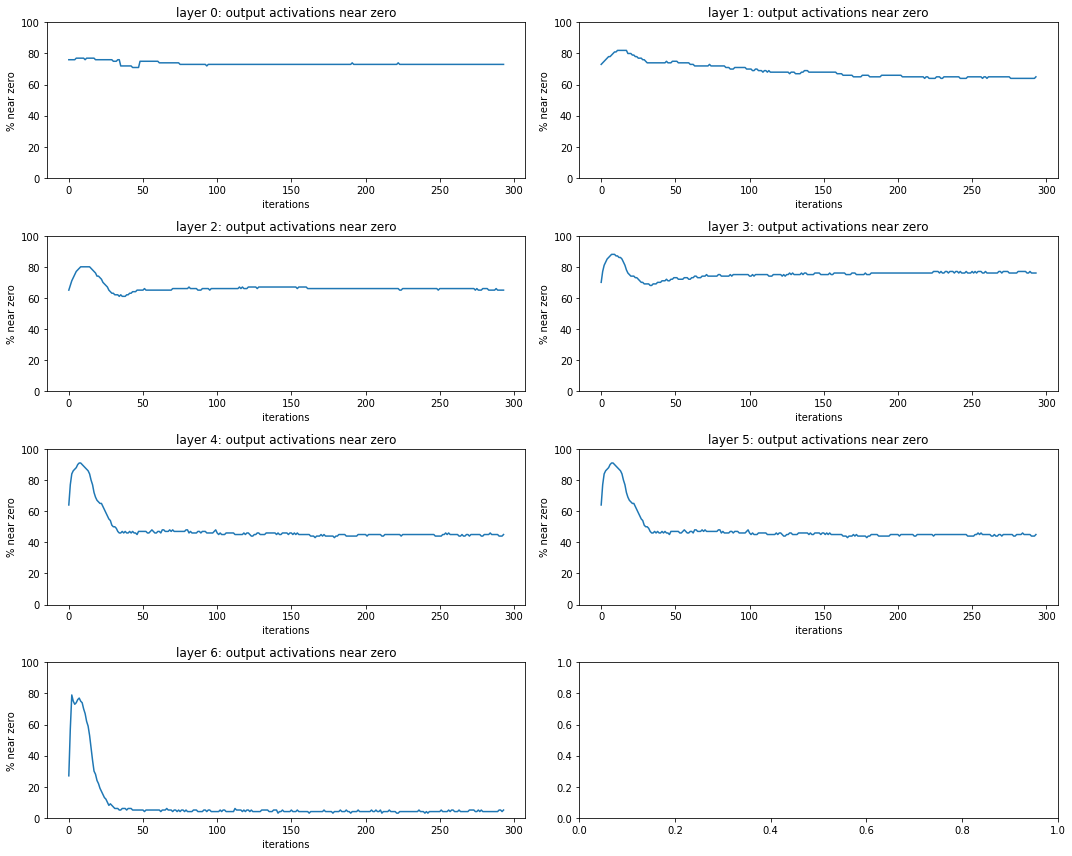

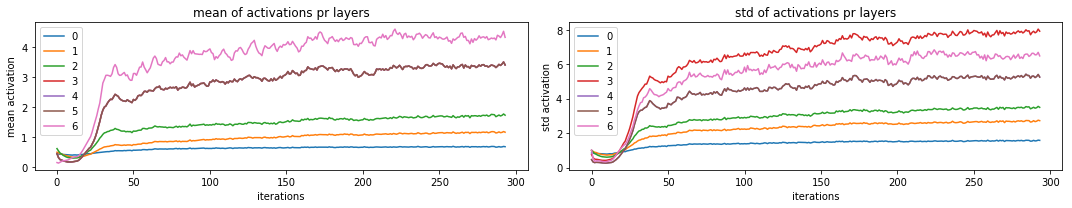

In [21]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

#model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out)()
#opt   = Adam(sched,max_lr=0.05, moms=(0.85,0.95), max_wd = 1e-3)
opt   = Adam(sched,max_lr=0.01, moms=(0.85,0.95), max_wd = 1e-5) # xresnet18
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
with Hooks(mm.model, append_stats) as hooks: 
    learn.fit(3, opt=opt, cb_funcs=cbfs)
    plot_layer_stats( hooks )

## mnist with LAMB and hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.854850,0.732300,0.179404,0.947100,00:10
1,0.143789,0.955660,0.094008,0.972600,00:09
2,0.090009,0.972140,0.076425,0.978100,00:08


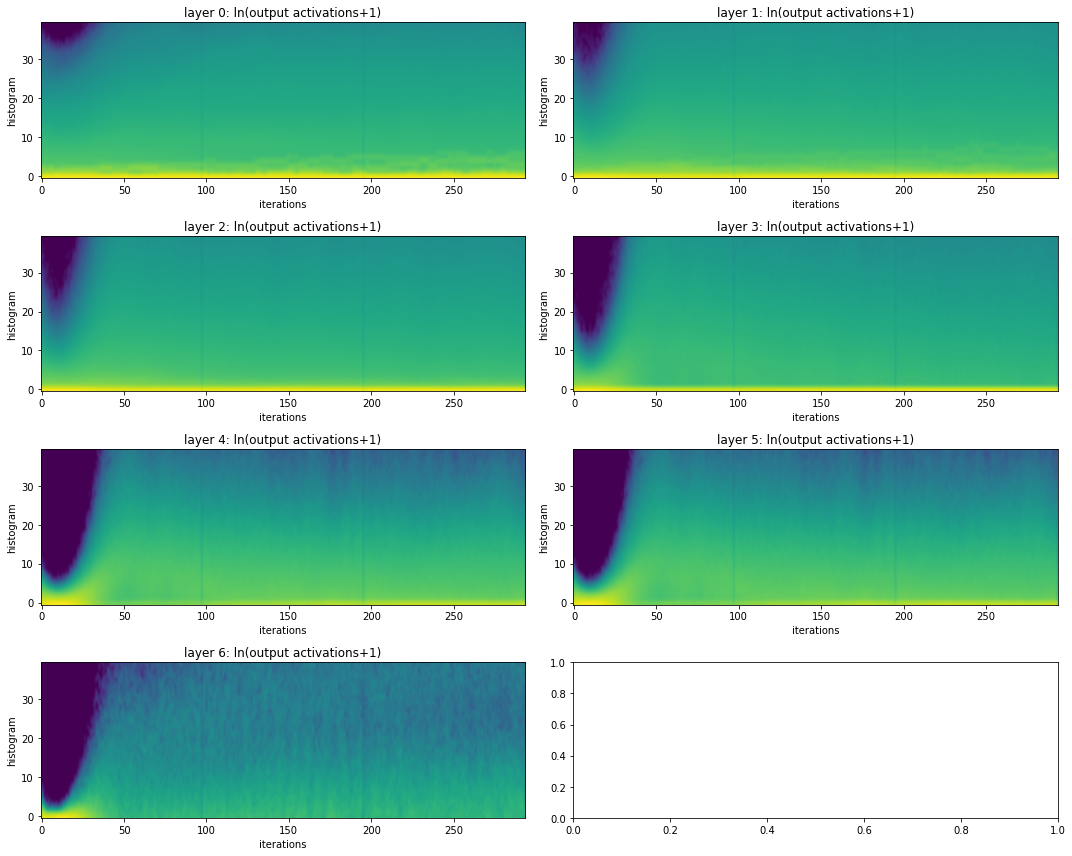

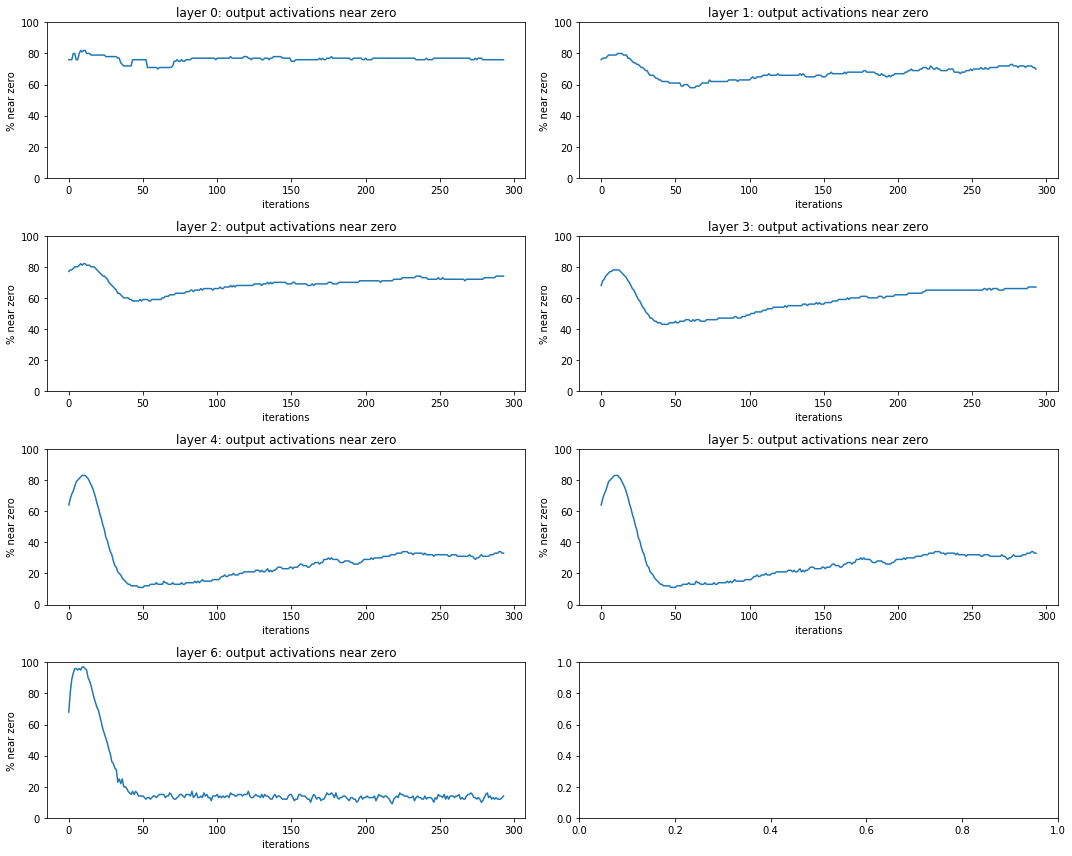

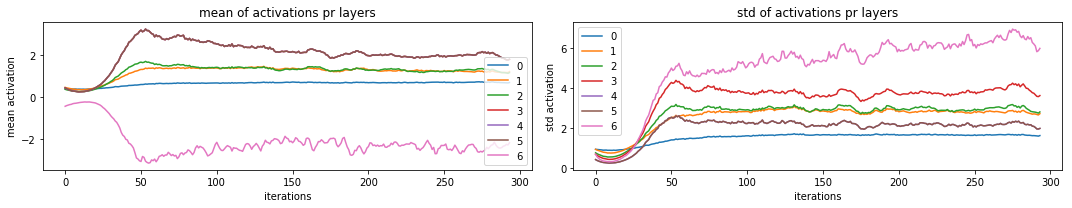

In [22]:
#model = CnnModelManager( partial(xresnet18, c_in=data.c_in, c_out=data.c_out)() )
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = LAMB(sched,max_lr=0.008, moms=(0.85,0.95), max_wd = 1e-6)     
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
with Hooks(mm.model, append_stats) as hooks: 
    learn.fit(3, opt=opt, cb_funcs=cbfs)
    plot_layer_stats( hooks )